## Get data from Github

In [1]:
!wget https://github.com/daniel-e/mnist_octave/raw/master/mnist.mat

--2019-10-19 18:53:29--  https://github.com/daniel-e/mnist_octave/raw/master/mnist.mat
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/daniel-e/mnist_octave/master/mnist.mat [following]
--2019-10-19 18:53:29--  https://raw.githubusercontent.com/daniel-e/mnist_octave/master/mnist.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14278089 (14M) [application/octet-stream]
Saving to: ‘mnist.mat.3’

mnist.mat.3         100%[===================>]  13.62M  --.-KB/s    in 0.1s    

2019-10-19 18:53:29 (125 MB/s) - ‘mnist.mat.3’ saved [14278089/14278089]



In [0]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

mat = scipy.io.loadmat('mnist.mat')

## Define 4 variables to hold the information from Github a little better

In [0]:
trainx = mat['trainX']
trainy = mat['trainY']
testx = mat['testX']
testy = mat['testY']

train = np.append(trainx, trainy.T, axis=1)
test = np.append(testx, testy.T, axis=1)

np.random.shuffle(train)
np.random.shuffle(test)

trainx = np.array(train[:, :784], dtype=np.float)
trainy = np.array(train[:, 784][np.newaxis].T, dtype=np.float)
testx = np.array(test[:, :784], dtype=np.float)
testy = np.array(test[:, 784][np.newaxis].T, dtype=np.float)


# Defining the major functions needed for the rest

In [0]:
def test_classification(trainX, mean, cov_mat, eig_pairs, trainY, testX, testY, test_size, funct, num_dim):
  #shortening the test size to what was passed in
  testX = testX[:test_size, :]

  #creating accuracy matrix, 10 by 10 for 0-9 classes
  acc = np.zeros((10, 10))

  #getting the eigenvectors and transposing, they're already sorted by decreasing effectiveness
  subspace = np.array([eig_pairs[i][1] for i in range(num_dim)]).T

  #projecting the training data onto the subspace
  trainX = trainX + mean
  trainX_pca = np.dot(trainX, subspace)

  #projecting the testing data onto the subspace
  testX_pca = np.dot(testX, subspace)

  #Doing 1st nearest neighbor using the projected training and testing
  for i in range(0, test_size):
    distances = funct(trainX_pca, testX_pca[i])    
    loc = np.argmin(distances)
    pred = int(trainY[loc, 0])
    actual = int(testY[i, 0])
    acc[actual, pred] += 1
  return acc


################################################################################


def get_pca_vars(trainx, train_size):
  trainx = trainx[:train_size, :]

  train_mean = np.mean(trainx, axis=0)
  train_diff = trainx - train_mean

  cov_mat = train_diff.T.dot(train_diff) / (train_diff.shape[0] - 1)

  eig_vals, eig_vecs = np.linalg.eig(cov_mat)

  eig_pairs = [(eig_vals[i], eig_vecs[:, i]) for i in range(len(eig_vals))]
  eig_pairs.sort(key=lambda x: x[0], reverse=True)

  return train_mean, train_diff, cov_mat, eig_pairs

In [0]:
def euclidean(train, test):
  return np.sqrt(np.sum(np.square(train - test), axis=1))

# Getting the data for both the euclidean function and cosine function

In [80]:
test = {}
test_size = 1000
fig1_data = np.array([])

for ix in range(500, 10500, 500):
  for i in range(1, 31):
    print('testing ', ix, ' training images with ', i, ' dimensions')
    mean, trainx_diff, cov_mat, eig_pairs = get_pca_vars(trainx, ix)
    fig1_data = np.append(fig1_data,  [ix, i, np.sum(test_classification(trainx_diff, mean, cov_mat, eig_pairs, trainy, testx, testy, test_size, euclidean, i).diagonal())/test_size])

fig1_data = np.reshape(fig1_data, (int(fig1_data.shape[0]/3), 3))

testing  500  training images with  1  dimensions
testing  500  training images with  2  dimensions
testing  500  training images with  3  dimensions
testing  500  training images with  4  dimensions
testing  500  training images with  5  dimensions
testing  500  training images with  6  dimensions
testing  500  training images with  7  dimensions
testing  500  training images with  8  dimensions
testing  500  training images with  9  dimensions
testing  500  training images with  10  dimensions
testing  500  training images with  11  dimensions
testing  500  training images with  12  dimensions
testing  500  training images with  13  dimensions
testing  500  training images with  14  dimensions
testing  500  training images with  15  dimensions
testing  500  training images with  16  dimensions
testing  500  training images with  17  dimensions
testing  500  training images with  18  dimensions
testing  500  training images with  19  dimensions
testing  500  training images with  20  

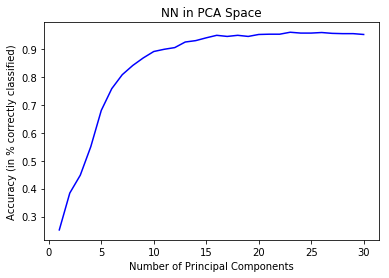

In [81]:
plot_main(fig1_data[np.where(fig1_data[:, 0] == 10000)[0]][:, [1, 2]], 'NN in PCA Space', 'Number of Principal Components', 'Accuracy (in % correctly classified)')

Text(0.5, 0, 'Accuracy')

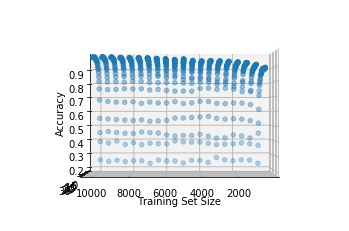

In [100]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(fig1_data[:, 0], fig1_data[:, 1], fig1_data[:, 2])
ax.view_init(0, 90)
ax.set_xlabel('Training Set Size')
ax.set_zlabel('Accuracy')

In [0]:
def plot_main(info, title, x_label, y_label):
  fig, ax = plt.subplots(1,1)
  ax.plot(info[:, 0], info[:, 1], 'b-')
  ax.set_title(title)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

In [0]:
def plot(conf, title, x_label, y_label):
  plot = np.copy(conf)
  plot_max = np.amax(plot)
  np.fill_diagonal(plot, 0)
  plot = plot / plot_max

  fig, ax1 = plt.subplots()
  pos = ax1.imshow(plot)
  plt.title(title)
  plt.ylabel(y_label)
  plt.xlabel(x_label)
  fig.colorbar(pos, ax=ax1)

def plot_hist(conf, title, x_label, y_label):
  plot = np.copy(conf)
  total = np.sum(plot, axis = 0)
  temp = np.copy(plot)
  np.fill_diagonal(temp, 0)
  errors = np.sum(temp, axis=0)

  data = np.array([])
  for i in range(0, 10):
    data = np.append(data, [i, errors[i]/total[i]])
  data = np.reshape(data, (10, 2))

  plt.bar(data[:, 0], data[:, 1], align='center')
  plt.xticks(data[:, 0])
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
